In [136]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as tdist
from scipy.stats import pearsonr
torch.set_num_threads(20)

In [2]:
M = 3  # total number of datasets
N = 1000  # total number of samples
d = 5  # latent variable z dimension
y_dims = torch.tensor([20, 30, 50])  # dimensions of each dataset
x_dims = torch.tensor([4, 5, 6])


In [3]:
# slightly weird simulation seed values
def generate_W_L_Phi(y_dims, x_dims, d=5, M=3, minval=-100, maxval=100, max_noise=5):
    all_Ws = []
    all_Ls = []
    all_Phis = []
    
    for i, y_val in enumerate(y_dims):
        # declare new uniform distributions from which to sample ground truth W, L, and Phi for each dataset
        W_uniform = tdist.uniform.Uniform(torch.ones(y_val, d)*minval, torch.ones(y_val, d)*maxval)
        L_uniform = tdist.uniform.Uniform(torch.ones(y_val, x_dims[i])*minval, torch.ones(y_val, x_dims[i])*maxval)
        Phi_uniform = tdist.uniform.Uniform(torch.zeros(y_val), max_noise*torch.ones(y_val))

        # store ground truth W, L, and Phi
        all_Ws.append(W_uniform.sample())
        all_Ls.append(L_uniform.sample())
        all_Phis.append(torch.diag(Phi_uniform.sample()))
    
    return all_Ws, all_Ls, all_Phis

# standard normals for W and L, identity for Phi
def generate_W_L_gaussian_Phi_identity(y_dims, x_dims, W_stdev=2.0, L_stdev=2.0):
    all_Ws = []
    all_Ls = []
    all_Phis = []
    
    for i, y_val in enumerate(y_dims):
        # declare new uniform distributions from which to sample ground truth W, L, and Phi for each dataset
        W_dist = tdist.normal.Normal(torch.zeros(y_val, d), torch.ones(y_val, d) * W_stdev)
        L_dist = tdist.normal.Normal(torch.zeros(y_val, x_dims[i]), torch.ones(y_val, x_dims[i]) * L_stdev)

        # store ground truth W, L, and Phi
        all_Ws.append(W_dist.sample())
        all_Ls.append(L_dist.sample())

        # append identity matrix instead of sampling uniform values
        all_Phis.append(torch.eye(y_val))
        
    return all_Ws, all_Ls, all_Phis


In [4]:
# all_Ws, all_Ls, all_Phis = generate_W_L_Phi(y_dims, x_dims)
all_Ws, all_Ls, all_Phis = generate_W_L_gaussian_Phi_identity(y_dims, x_dims)
print([W.shape for W in all_Ws])
print([L.shape for L in all_Ls])
print([Phi.shape for Phi in all_Phis])

[torch.Size([20, 5]), torch.Size([30, 5]), torch.Size([50, 5])]
[torch.Size([20, 4]), torch.Size([30, 5]), torch.Size([50, 6])]
[torch.Size([20, 20]), torch.Size([30, 30]), torch.Size([50, 50])]


In [5]:
def generate_samples(all_Ws, all_Ls, all_Phis, y_dims, x_dims, N=1000, d=5):
    datasets = [torch.zeros(1, y_d) for y_d in y_dims]

    # z-distribution remains fixed
    z_distribution = tdist.multivariate_normal.MultivariateNormal(torch.zeros(d), torch.eye(d))
    
    # simulate the graphical model
    for sample in range(N):
        print('Generating sample: {}/{}'.format(sample, N), end='\r', flush=True)
        # for each sample, retrieve the latent z latent variable
        z = z_distribution.sample()
        # for each dataset, compute the dataset-specific mean and variance, and obtain 1 sample
        for i, dim in enumerate(x_dims):
            x = tdist.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.eye(dim)).sample()
            y_i = tdist.multivariate_normal.MultivariateNormal(all_Ws[i] @ z + all_Ls[i] @ x, all_Phis[i]).sample()
            datasets[i] = torch.cat([datasets[i], y_i[None,:]])
    datasets = [dataset[1:] for dataset in datasets]      
    return datasets

In [6]:
# generate datasets according to simulation
datasets = generate_samples(all_Ws, all_Ls, all_Phis, y_dims, x_dims, N=N, d=d)
# concatenate the y-vectors for each sample together
y_concat = torch.cat(datasets, axis=1)
y_concat_T = y_concat.T
print(y_concat_T.shape)

torch.Size([100, 1000])1000


In [7]:
# we have the low-rank structure and shit here
def initialize_model(y_dims, x_dims, datasets, d=5, std=2, mean=0):
    Ws_to_stack = []
    Phis_to_stack = []
    Ls_to_stack = []
    
    for i, y_dim in enumerate(y_dims):
        # set W and L to standard normal initialization around 0 
        cur_W = torch.nn.init.normal_(torch.zeros(y_dim, d), mean=mean, std=std)
        cur_L = torch.nn.init.normal_(torch.zeros(y_dim, x_dims[i]), mean=mean, std=std)

        # set Phi to the empirical covariance matrix 
        cur_dataset = datasets[i] # (n_samples x dimension)
        ymu = torch.mean(cur_dataset, axis=0, keepdim=True)
        cur_dataset = cur_dataset - ymu
        
        # due to design matrix construction, covariance = 1/n(Y^T Y)
        cur_Phi = (1/cur_dataset.shape[0]) * cur_dataset.T @ cur_dataset

        Ws_to_stack.append(cur_W)
        Ls_to_stack.append(cur_L)
        Phis_to_stack.append(cur_Phi)

    return torch.cat(Ws_to_stack, axis=0), torch.block_diag(*Ls_to_stack), torch.block_diag(*Phis_to_stack)

In [8]:
# compute the ground-truth parameters
W_GT = torch.cat(all_Ws, axis=0)
L_GT = torch.block_diag(*all_Ls)
Phi_GT = torch.block_diag(*all_Phis)
# initialize the model parameters
W_model, L_model, Phi_model = initialize_model(y_dims, x_dims, datasets)

In [9]:
# the E-Step required values (is there a way to batch this intelligently?)
def E_step(W, L, Phi, x_dims, d, y_i):
    # schur-complement (M/D)^{-1}; need to make sure that this is not blowing up!
    sigma_22_inv = torch.inverse(W@W.T + L @ L.T + Phi)
    #     print(sigma_22_inv)

    # other necessary block matrices
    sigma_12 = torch.cat([W.T, L.T], axis=0)
    sigma_11 = torch.eye(torch.sum(x_dims)+d)

    # compute the posterior mean of z and x; y should be a matrix with all samples aligned as columns
    posterior_z_x_mean = sigma_12 @ sigma_22_inv @ (y_i)
    posterior_z_mean = posterior_z_x_mean[:d]
    posterior_x_mean = posterior_z_x_mean[d:]

    # posterior covariance
    posterior_x1_cov = sigma_11 - sigma_12 @ sigma_22_inv @ sigma_12.T
    posterior_z_x_cov = posterior_x1_cov[:d, d:]  # cross covariance
    posterior_z_z_cov = posterior_x1_cov[:d, :d]  # upper left block matrix
    posterior_x_x_cov = posterior_x1_cov[d:, d:]  # bottom right block matrix
    
    # need to batch zmu and xmu: [n_samples, <[z, x]>.shape, 1]
    zmu_batched = posterior_z_mean.T[:, :, None]
    xmu_batched = posterior_x_mean.T[:, :, None]

    # posterior <zx.T> = cov(z, x) + <z><x.T>
    posterior_zxT = posterior_z_x_cov + zmu_batched @ xmu_batched.permute(0, 2, 1)  # shape: (n_samples, z_dim, x_dim)
    posterior_zzT = posterior_z_z_cov + zmu_batched @ zmu_batched.permute(0, 2, 1)  # shape: (n_samples, z_dim, z_dim)
    posterior_xxT = posterior_x_x_cov + xmu_batched @ xmu_batched.permute(0, 2, 1)  # shape: (n_samples, x_dim, x_dim)

    return posterior_zxT, posterior_zzT, posterior_xxT, zmu_batched, xmu_batched

def M_step(zxT, zzT, xxT, zmu, xmu, y_i, Phi_model, L_model, W_model, N):
    y_i_batched = y_i[:, :, None]  # (n_samples, batch_dim, 1)
    new_L = torch.sum(y_i_batched @ xmu.permute(0, 2, 1) - W_model @ zxT, axis=0) @ torch.inverse(torch.sum(xxT, axis=0))
    new_W = torch.sum(y_i_batched @ zmu.permute(0, 2, 1) - L_model @ zxT.permute(0, 2, 1), axis=0) @ torch.inverse(torch.sum(zzT, axis=0))
    
    phi_term_1 = 2 / N * torch.sum( (L_model @ xmu + W_model @ zmu) @ y_i_batched.permute(0, 2, 1), axis=0)
    phi_term_2 = -1 / N * torch.sum(y_i_batched @ y_i_batched.permute(0, 2, 1), axis=0)
    phi_term_3 = -1 / N * torch.sum( (L_model @ xxT @ L_model.T) + W_model @ zzT @ W_model.T + 2 * L_model @ zxT.permute(0, 2, 1) @ W_model.T, axis=0)
    new_Phi = torch.inverse(phi_term_1 + phi_term_2 + phi_term_3)

    #     print(phi_term_1.shape)
    #     print(phi_term_2.shape)
    #     print(new_L.shape)
    #     print(new_W.shape)    
    
    return new_W, new_L, new_Phi

In [10]:
zxT, zzT, xxT, zmu, xmu = E_step(W_model, L_model, Phi_model, x_dims, d, y_concat_T)
new_W, new_L, new_Phi = M_step(zxT, zzT, xxT, zmu, xmu, y_concat, Phi_model, L_model, W_model, N)

In [11]:
# Experiment Set Phi = Phi_GT and don't update it in the M-Step
plt.rcParams['figure.figsize'] = (10, 10)
def M_step(zxT, zzT, xxT, zmu, xmu, y_i, Phi_model, L_model, W_model, N):
    y_i_batched = y_i[:, :, None]  # (n_samples, batch_dim, 1)
    new_L = torch.sum(y_i_batched @ xmu.permute(0, 2, 1) - W_model @ zxT, axis=0) @ torch.inverse(torch.sum(xxT, axis=0))
    new_W = torch.sum(y_i_batched @ zmu.permute(0, 2, 1) - L_model @ zxT.permute(0, 2, 1), axis=0) @ torch.inverse(torch.sum(zzT, axis=0))
    new_Phi = Phi_model # Experiment Set Phi = Phi_GT and don't update it in the M-Step

    return new_W, new_L, new_Phi


# number of E/M-Steps To Run
steps = 10000
# initialize the model parameters
W_model, L_model, Phi_model = initialize_model(y_dims, x_dims, datasets)
# stop training when the F-norm b/w current/prev update is too small
eps = 1e-6

# ground truth (GT) values
W_GT = torch.cat(all_Ws, axis=0)
L_GT = torch.block_diag(*all_Ls)
Phi_GT = torch.block_diag(*all_Phis)

# EXPERIMENT: Set Phi=Phi_GT and never update it; do we get convergence?
Phi_model = Phi_GT

# Check initial F-Norm
W_norm = torch.norm(W_GT - W_model).item()
L_norm = torch.norm(L_GT - L_model).item()
Phi_norm = torch.norm(Phi_GT - Phi_model).item()
print("-"*100)
print("Initial F-Norm (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(W_norm, L_norm, Phi_norm))
print("-"*100)

# store the reconstruction error
W_losses = []
L_losses = []
Phi_losses = []

# iterate through E/M Steps
for i in range(steps):
    # E-Step, then M-Step
    zxT, zzT, xxT, zmu, xmu = E_step(W_model, L_model, Phi_model, x_dims, d, y_concat_T)
    W_tprime, L_tprime, Phi_tprime = M_step(zxT, zzT, xxT, zmu, xmu, y_concat, Phi_model, L_model, W_model, N)

    # F-norm between current estimators and true values
    W_norm = torch.norm(W_GT - W_model).item()
    L_norm = torch.norm(L_GT - L_model).item()
    Phi_norm = torch.norm(Phi_GT - Phi_model).item()

    # F-norm between prev params and updated
    W_diff = torch.norm(W_tprime-W_model).item()
    L_diff = torch.norm(L_tprime-L_model).item()
    Phi_diff = torch.norm(Phi_tprime - Phi_model).item()

    # store training stats
    W_losses.append(W_norm)
    L_losses.append(L_norm)
    Phi_losses.append(Phi_norm)
    
    # update parameters
    W_model = W_tprime
    L_model = L_tprime
    Phi_model = Phi_tprime

    if W_diff <= eps and L_diff <= eps and Phi_diff <= eps:
        print('Stopping... step between W_t, W_t+1 <= {}'.format(eps))
        break

    if (i % 100 == 0):
        print("{}/{}: (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(i, steps, W_norm, L_norm, Phi_norm))

W_norm = torch.norm(W_GT - W_model).item()
L_norm = torch.norm(L_GT - L_model).item()
Phi_norm = torch.norm(Phi_GT - Phi_model).item()

print("-"*100)
print("Steps: {} (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(i, W_norm, L_norm, Phi_norm))
plt.plot(np.arange(i+1), W_losses)
plt.grid()
plt.ylabel('F-Norm Between W_hat and W during Training')
plt.xlabel('Training Step')
plt.title('Training Error for W when Phi Fixed to Ground Truth')
plt.savefig('./phi_fixed_updates_to_W.png')
plt.show()
plt.clf()
plt.plot(np.arange(i+1), L_losses)
plt.grid()
plt.ylabel('F-Norm Between L_hat and L During Training')
plt.xlabel('Training Step')
plt.title('Training Error for L when Phi Fixed to Ground Truth')
plt.savefig('./phi_fixed_updates_to_L.png')
plt.show()
plt.clf()



----------------------------------------------------------------------------------------------------
Initial F-Norm (W-WGT)_F: 64.50350952148438 (L-LGT)_F: 62.89799499511719 (Phi-PhiGT)_F: 0.0
----------------------------------------------------------------------------------------------------
0/10000: (W-WGT)_F: 64.50350952148438 (L-LGT)_F: 62.89799499511719 (Phi-PhiGT)_F: 0.0
100/10000: (W-WGT)_F: 122.84085845947266 (L-LGT)_F: 109.40042877197266 (Phi-PhiGT)_F: 0.0
200/10000: (W-WGT)_F: 113.50883483886719 (L-LGT)_F: 97.88861083984375 (Phi-PhiGT)_F: 0.0
300/10000: (W-WGT)_F: 107.22748565673828 (L-LGT)_F: 91.62608337402344 (Phi-PhiGT)_F: 0.0
400/10000: (W-WGT)_F: 102.14071655273438 (L-LGT)_F: 87.34500122070312 (Phi-PhiGT)_F: 0.0
500/10000: (W-WGT)_F: 97.47052764892578 (L-LGT)_F: 83.90221405029297 (Phi-PhiGT)_F: 0.0
600/10000: (W-WGT)_F: 93.15645599365234 (L-LGT)_F: 80.94575500488281 (Phi-PhiGT)_F: 0.0
700/10000: (W-WGT)_F: 89.21084594726562 (L-LGT)_F: 78.37439727783203 (Phi-PhiGT)_F: 0.0

KeyboardInterrupt: 

In [253]:
# Experiment Set everything equal to ground truth, keeping Phi fixed for now
# check that the EM-algorithm doesn't move the values too much
plt.rcParams['figure.figsize'] = (10, 10)
def M_step(zxT, zzT, xxT, zmu, xmu, y_i, Phi_model, L_model, W_model, N):
    y_i_batched = y_i[:, :, None]  # (n_samples, batch_dim, 1)
    new_L = torch.sum(y_i_batched @ xmu.permute(0, 2, 1) - W_model @ zxT, axis=0) @ torch.inverse(torch.sum(xxT, axis=0))
    new_W = torch.sum(y_i_batched @ zmu.permute(0, 2, 1) - L_model @ zxT.permute(0, 2, 1), axis=0) @ torch.inverse(torch.sum(zzT, axis=0))
    new_Phi = Phi_model # Experiment Set Phi = Phi_GT and don't update it in the M-Step

    return new_W, new_L, new_Phi


# number of E/M-Steps To Run
steps = 5000
# initialize the model parameters
W_model, L_model, Phi_model = initialize_model(y_dims, x_dims, datasets)
# stop training when the F-norm b/w current/prev update is too small
eps = 1e-6

# ground truth (GT) values
W_GT = torch.cat(all_Ws, axis=0)
L_GT = torch.block_diag(*all_Ls)
Phi_GT = torch.block_diag(*all_Phis)

# EXPERIMENT: Set model parameters = ground truth (Phi still fixed):
# Does the EM Algorithm not budge too much?
Phi_model = Phi_GT
W_model = W_GT
L_model = L_GT

# Check initial F-Norm
W_norm = torch.norm(W_GT - W_model).item()
L_norm = torch.norm(L_GT - L_model).item()
Phi_norm = torch.norm(Phi_GT - Phi_model).item()
print("-"*100)
print("Initial F-Norm (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(W_norm, L_norm, Phi_norm))
print("-"*100)

# store the reconstruction error
W_losses = []
L_losses = []
Phi_losses = []

# iterate through E/M Steps
for i in range(steps):
    # E-Step, then M-Step
    zxT, zzT, xxT, zmu, xmu = E_step(W_model, L_model, Phi_model, x_dims, d, y_concat_T)
    W_tprime, L_tprime, Phi_tprime = M_step(zxT, zzT, xxT, zmu, xmu, y_concat, Phi_model, L_model, W_model, N)

    # F-norm between current estimators and true values
    W_norm = torch.norm(W_GT - W_model).item()
    L_norm = torch.norm(L_GT - L_model).item()
    Phi_norm = torch.norm(Phi_GT - Phi_model).item()

    # F-norm between prev params and updated
    W_diff = torch.norm(W_tprime-W_model).item()
    L_diff = torch.norm(L_tprime-L_model).item()
    Phi_diff = torch.norm(Phi_tprime - Phi_model).item()

    # store training stats
    W_losses.append(W_norm)
    L_losses.append(L_norm)
    Phi_losses.append(Phi_norm)
    
    # update parameters
    W_model = W_tprime
    L_model = L_tprime
    Phi_model = Phi_tprime

    if W_diff <= eps and L_diff <= eps and Phi_diff <= eps:
        print('Stopping... step between W_t, W_t+1 <= {}'.format(eps))
        break

    if (i % 100 == 0):
        print("{}/{}: (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(i, steps, W_norm, L_norm, Phi_norm))

W_norm = torch.norm(W_GT - W_model).item()
L_norm = torch.norm(L_GT - L_model).item()
Phi_norm = torch.norm(Phi_GT - Phi_model).item()

print("-"*100)
print("Steps: {} (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(i, W_norm, L_norm, Phi_norm))
plt.plot(np.arange(i+1), W_losses)
plt.grid()
plt.ylabel('F-Norm Between W_hat and W during Training')
plt.xlabel('Training Step')
plt.title('Training Error for W when Initialized to Ground Truth')
plt.savefig('./phi_fixed_updates_to_W.png')
plt.show()
plt.clf()
plt.plot(np.arange(i+1), L_losses)
plt.grid()
plt.ylabel('F-Norm Between L_hat and L During Training')
plt.xlabel('Training Step')
plt.title('Training Error for L when Initialized to Ground Truth')
plt.savefig('./phi_fixed_updates_to_L.png')
plt.show()
plt.clf()



----------------------------------------------------------------------------------------------------
Initial F-Norm (W-WGT)_F: 0.0 (L-LGT)_F: 0.0 (Phi-PhiGT)_F: 0.0
----------------------------------------------------------------------------------------------------
0/5000: (W-WGT)_F: 0.0 (L-LGT)_F: 0.0 (Phi-PhiGT)_F: 0.0
100/5000: (W-WGT)_F: 1.7865512371063232 (L-LGT)_F: 2.53092622756958 (Phi-PhiGT)_F: 0.0
200/5000: (W-WGT)_F: 2.349980592727661 (L-LGT)_F: 3.003384590148926 (Phi-PhiGT)_F: 0.0
300/5000: (W-WGT)_F: 2.6266984939575195 (L-LGT)_F: 3.174431800842285 (Phi-PhiGT)_F: 0.0
400/5000: (W-WGT)_F: 2.777111768722534 (L-LGT)_F: 3.248866319656372 (Phi-PhiGT)_F: 0.0
500/5000: (W-WGT)_F: 2.864664316177368 (L-LGT)_F: 3.2855098247528076 (Phi-PhiGT)_F: 0.0
600/5000: (W-WGT)_F: 2.916839599609375 (L-LGT)_F: 3.3052878379821777 (Phi-PhiGT)_F: 0.0
700/5000: (W-WGT)_F: 2.9497880935668945 (L-LGT)_F: 3.3166394233703613 (Phi-PhiGT)_F: 0.0
800/5000: (W-WGT)_F: 2.969542980194092 (L-LGT)_F: 3.32335877418

KeyboardInterrupt: 

In [168]:
# EXPERIMENT: Use isotropic noise variance that is the same across all of the y_i, allowing for the L to account for 
# different true variance and covariance conditioned on the y_i

def initialize_isotropic_model(y_dims, x_dims, datasets, d=5, std=2, mean=0):
    Ws_to_stack = []
    Phis_to_stack = []
    Ls_to_stack = []
    
    for i, y_dim in enumerate(y_dims):
        # set W and L to standard normal initialization around 0 
        cur_W = torch.nn.init.normal_(torch.zeros(y_dim, d), mean=mean, std=std)
        cur_L = torch.nn.init.normal_(torch.zeros(y_dim, x_dims[i]), mean=mean, std=std)

        # set Phi to the empirical covariance matrix 
        cur_dataset = datasets[i] # (n_samples x dimension)
        ymu = torch.mean(cur_dataset, axis=0, keepdim=True)
        cur_dataset = cur_dataset - ymu
        
        # due to design matrix construction, covariance = 1/n(Y^T Y)
        cur_Phi = (1/cur_dataset.shape[0]) * cur_dataset.T @ cur_dataset

        Ws_to_stack.append(cur_W)
        Ls_to_stack.append(cur_L)
        Phis_to_stack.append(cur_Phi)
    
    # get the current phi matrix
    cur_Phi = torch.block_diag(*Phis_to_stack)

    # we're fixing an *isotropic* variance assumption here, so the model variance will be captured by a *scalar*
    variance = 1/cur_Phi.shape[0] * torch.einsum('ii->', cur_Phi)
    assert variance >= 0 
    return torch.cat(Ws_to_stack, axis=0), torch.block_diag(*Ls_to_stack), variance

# the E-Step required values (is there a way to batch this intelligently?)
def isotropic_E_step(W, L, Phi, x_dims, d, y_i):
    # schur-complement (M/D)^{-1}; need to make sure that this is not blowing up!
    # Phi is a scalar now! (Phi = \sigma^2)
    sigma_22_inv = torch.inverse(W@W.T + L @ L.T + Phi*torch.eye(W.shape[0]))
    #     print(sigma_22_inv)

    # other necessary block matrices
    sigma_12 = torch.cat([W.T, L.T], axis=0)
    sigma_11 = torch.eye(torch.sum(x_dims)+d)

    # compute the posterior mean of z and x; y should be a matrix with all samples aligned as columns
    posterior_z_x_mean = sigma_12 @ sigma_22_inv @ (y_i)
    posterior_z_mean = posterior_z_x_mean[:d]
    posterior_x_mean = posterior_z_x_mean[d:]

    # posterior covariance
    posterior_x1_cov = sigma_11 - sigma_12 @ sigma_22_inv @ sigma_12.T
    posterior_z_x_cov = posterior_x1_cov[:d, d:]  # cross covariance
    posterior_z_z_cov = posterior_x1_cov[:d, :d]  # upper left block matrix
    posterior_x_x_cov = posterior_x1_cov[d:, d:]  # bottom right block matrix
    
    # need to batch zmu and xmu: [n_samples, <[z, x]>.shape, 1]
    zmu_batched = posterior_z_mean.T[:, :, None]
    xmu_batched = posterior_x_mean.T[:, :, None]

    # posterior <zx.T> = cov(z, x) + <z><x.T>
    posterior_zxT = posterior_z_x_cov + zmu_batched @ xmu_batched.permute(0, 2, 1)  # shape: (n_samples, z_dim, x_dim)
    posterior_zzT = posterior_z_z_cov + zmu_batched @ zmu_batched.permute(0, 2, 1)  # shape: (n_samples, z_dim, z_dim)
    posterior_xxT = posterior_x_x_cov + xmu_batched @ xmu_batched.permute(0, 2, 1)  # shape: (n_samples, x_dim, x_dim)

    return posterior_zxT, posterior_zzT, posterior_xxT, zmu_batched, xmu_batched

def isotropic_M_step(zxT, zzT, xxT, zmu, xmu, y_i, Phi_model, L_model, W_model, N):
    y_i_batched = y_i[:, :, None]  # (n_samples, batch_dim, 1)
    new_L = torch.sum(y_i_batched @ xmu.permute(0, 2, 1) - W_model @ zxT, axis=0) @ torch.inverse(torch.sum(xxT, axis=0))
    new_W = torch.sum(y_i_batched @ zmu.permute(0, 2, 1) - L_model @ zxT.permute(0, 2, 1), axis=0) @ torch.inverse(torch.sum(zzT, axis=0))

    # compute terms involving y_i_batched 
    var_terms = []
    var_terms.append(1/2*torch.sum(y_i_batched.permute(0, 2, 1) @ y_i_batched))
    var_terms.append(-1 * torch.sum(y_i_batched.permute(0, 2, 1) @ W_model @ zmu))
    var_terms.append(-1 * torch.sum(y_i_batched.permute(0, 2, 1) @ L_model @ xmu))

    # einsum does a batched trace
    var_terms.append(1/2 * torch.sum(torch.einsum('bii->b', W_model.T @ W_model @ zzT)))
    var_terms.append(1/2 * torch.sum(torch.einsum('bii->b', L_model.T @ L_model @ xxT)))
    var_terms.append(1/2 * torch.sum(torch.einsum('bii->b', L_model.T @ W_model @ zxT)))

    new_Phi =  torch.sum(2 / (N * y_i.shape[1]) * torch.tensor(var_terms)) 
    return new_W, new_L, new_Phi

In [169]:
# compute the ground-truth parameters
W_GT = torch.cat(all_Ws, axis=0)
L_GT = torch.block_diag(*all_Ls)
Phi_GT = torch.block_diag(*all_Phis)
# initialize the model parameters
W_model, L_model, Phi_model = initialize_isotropic_model(y_dims, x_dims, datasets)

In [170]:
zxT, zzT, xxT, zmu, xmu = isotropic_E_step(W_model, L_model, Phi_model, x_dims, d, y_concat_T)
new_W, new_L, new_Phi = isotropic_M_step(zxT, zzT, xxT, zmu, xmu, y_concat, Phi_model, L_model, W_model, N)

----------------------------------------------------------------------------------------------------
Initial F-Norm (W-WGT)_F: 63.81549072265625 (L-LGT)_F: 61.968017578125 (Phi-PhiGT)_F: 376.99749755859375
----------------------------------------------------------------------------------------------------
0/5000: (W-WGT)_F: 63.81549072265625 (L-LGT)_F: 61.968017578125 (Phi-PhiGT)_F: 376.99749755859375


/gpfs/commons/home/cwang/miniconda3/envs/cca/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


100/5000: (W-WGT)_F: 68.5291748046875 (L-LGT)_F: 60.43781661987305 (Phi-PhiGT)_F: 7.647226810455322
200/5000: (W-WGT)_F: 66.63590240478516 (L-LGT)_F: 60.283409118652344 (Phi-PhiGT)_F: 3.589076519012451
300/5000: (W-WGT)_F: 65.75430297851562 (L-LGT)_F: 60.1833381652832 (Phi-PhiGT)_F: 1.9821749925613403
400/5000: (W-WGT)_F: 65.27660369873047 (L-LGT)_F: 60.12813949584961 (Phi-PhiGT)_F: 1.1768726110458374
500/5000: (W-WGT)_F: 64.99623107910156 (L-LGT)_F: 60.097572326660156 (Phi-PhiGT)_F: 0.7299232482910156
600/5000: (W-WGT)_F: 64.8230209350586 (L-LGT)_F: 60.080440521240234 (Phi-PhiGT)_F: 0.46417227387428284
700/5000: (W-WGT)_F: 64.7125244140625 (L-LGT)_F: 60.070831298828125 (Phi-PhiGT)_F: 0.2978706359863281
800/5000: (W-WGT)_F: 64.64025115966797 (L-LGT)_F: 60.0655632019043 (Phi-PhiGT)_F: 0.19382481276988983
900/5000: (W-WGT)_F: 64.59224700927734 (L-LGT)_F: 60.06249237060547 (Phi-PhiGT)_F: 0.12664794921875
1000/5000: (W-WGT)_F: 64.5595703125 (L-LGT)_F: 60.06101989746094 (Phi-PhiGT)_F: 0.079

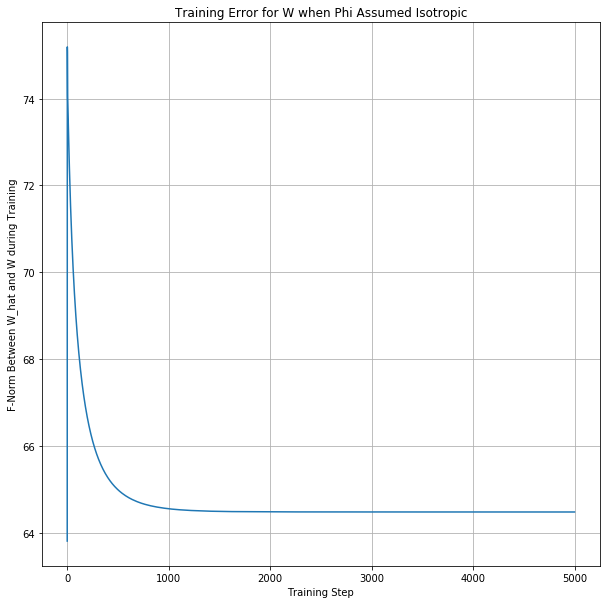

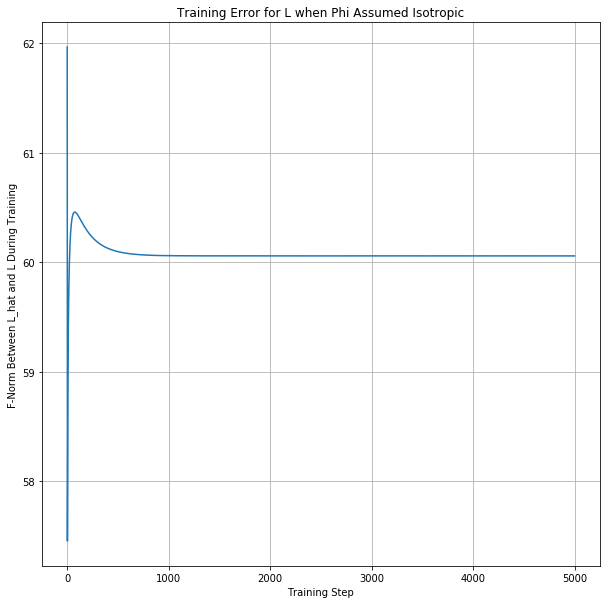

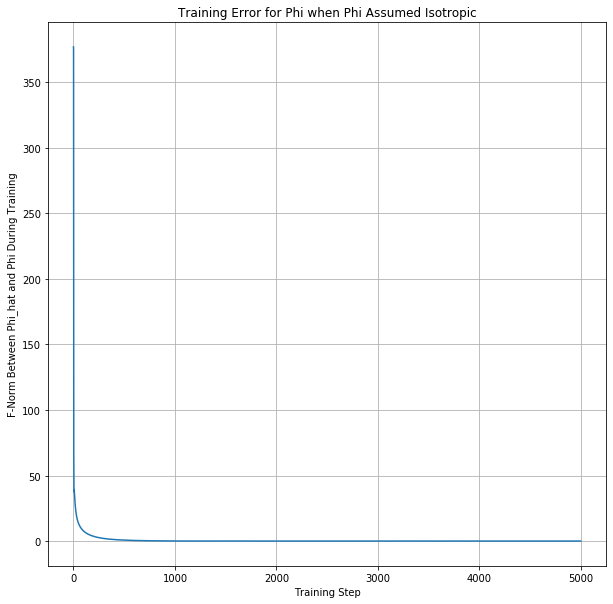

<Figure size 720x720 with 0 Axes>

In [171]:
# Experiment Set Phi = Phi_GT and don't update it in the M-Step
plt.rcParams['figure.figsize'] = (10, 10)

# number of E/M-Steps To Run
steps = 5000
# initialize the model parameters
W_model, L_model, Phi_model = initialize_isotropic_model(y_dims, x_dims, datasets)
# stop training when the F-norm b/w current/prev update is too small
eps = 1e-6

# ground truth (GT) values
W_GT = torch.cat(all_Ws, axis=0)
L_GT = torch.block_diag(*all_Ls)
Phi_GT = torch.block_diag(*all_Phis)

# Check initial F-Norm
W_norm = torch.norm(W_GT - W_model).item()
L_norm = torch.norm(L_GT - L_model).item()
Phi_norm = torch.norm(Phi_GT - Phi_model*torch.eye(Phi_GT.shape[0])).item()
print("-"*100)
print("Initial F-Norm (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(W_norm, L_norm, Phi_norm))
print("-"*100)

# store the reconstruction error
W_losses = []
L_losses = []
Phi_losses = []

# iterate through E/M Steps
for i in range(steps):
    # E-Step, then M-Step
    zxT, zzT, xxT, zmu, xmu = isotropic_E_step(W_model, L_model, Phi_model, x_dims, d, y_concat_T)
    W_tprime, L_tprime, Phi_tprime = isotropic_M_step(zxT, zzT, xxT, zmu, xmu, y_concat, Phi_model, L_model, W_model, N)

    # F-norm between current estimators and true values
    W_norm = torch.norm(W_GT - W_model).item()
    L_norm = torch.norm(L_GT - L_model).item()
    Phi_norm = torch.norm(Phi_GT - Phi_model*torch.eye(Phi_GT.shape[0])).item()

    # F-norm between prev params and updated
    W_diff = torch.norm(W_tprime-W_model).item()
    L_diff = torch.norm(L_tprime-L_model).item()
    Phi_diff = torch.norm(torch.tensor(Phi_tprime - Phi_model)).item()

    # store training stats
    W_losses.append(W_norm)
    L_losses.append(L_norm)
    Phi_losses.append(Phi_norm)
    
    # update parameters
    W_model = W_tprime
    Phi_model = Phi_tprime

    # careful when updating L_model; have to make sure to keep terms that allow
    # interaction of private structure across datasets fixed at 0 
    #     L_model = L_tprime

    for j in range(len(y_dims)):
        # only update the specific L_i corresponding to each dataset; keep 
        # zero-padded values that make the matrix multiplication work as 0
        bot_y = 0 if j == 0 else torch.sum(y_dims[:j])
        bot_x = 0 if j == 0 else torch.sum(x_dims[:j])
        #         print('({}:{}) x ({}:{})'.format(bot_y, bot_y + y_dims[j], bot_x, bot_x + x_dims[j]))
        L_model[bot_y:bot_y+y_dims[j], bot_x:bot_x+x_dims[j]] = L_tprime[bot_y:bot_y+y_dims[j], bot_x:bot_x+x_dims[j]]

    # check for convergence
    if W_diff <= eps and L_diff <= eps and Phi_diff <= eps:
        print('Stopping... step between W_t, W_t+1 <= {}'.format(eps))
        break

    # debugging
    if (i % 100 == 0):
        print("{}/{}: (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(i, steps, W_norm, L_norm, Phi_norm))

W_norm = torch.norm(W_GT - W_model).item()
L_norm = torch.norm(L_GT - L_model).item()
Phi_norm = torch.norm(Phi_GT - Phi_model).item()

print("-"*100)
print("Steps: {} (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(i, W_norm, L_norm, Phi_norm))
plt.plot(np.arange(i+1), W_losses)
plt.grid()
plt.ylabel('F-Norm Between W_hat and W during Training')
plt.xlabel('Training Step')
plt.title('Training Error for W when Phi Assumed Isotropic')
plt.savefig('./phi_isotropic_W_update.png')
plt.show()
plt.clf()

plt.plot(np.arange(i+1), L_losses)
plt.grid()
plt.ylabel('F-Norm Between L_hat and L During Training')
plt.xlabel('Training Step')
plt.title('Training Error for L when Phi Assumed Isotropic')
plt.savefig('./phi_isotropic_L_update.png')
plt.show()
plt.clf()

plt.plot(np.arange(i+1), Phi_losses)
plt.grid()
plt.ylabel('F-Norm Between Phi_hat and Phi During Training')
plt.xlabel('Training Step')
plt.title('Training Error for Phi when Phi Assumed Isotropic')
plt.savefig('./phi_isotropic_Phi_update.png')
plt.show()
plt.clf()



In [172]:
WWT_GT = W_GT @ W_GT.T
WWT_GT = WWT_GT.reshape(-1).numpy()
WWT_pred = W_model @ W_model.T
WWT_pred = WWT_pred.reshape(-1).numpy()

In [173]:
LLT_GT = L_GT @ L_GT.T
LLT_GT = LLT_GT.reshape(-1).numpy()
LLT_pred = L_model @ L_model.T
LLT_pred = LLT_pred.reshape(-1).numpy()

(0.9972826378912208, 0.0)


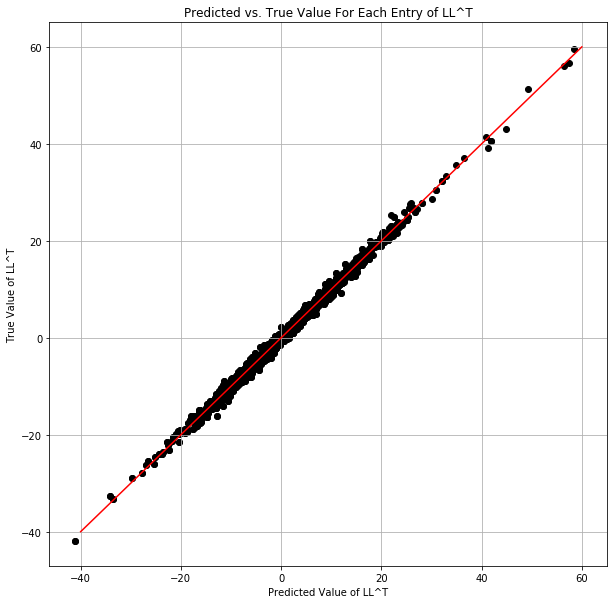

In [174]:
x = np.linspace(-40, 60, 100)
y = x
plt.scatter(LLT_pred, LLT_GT, color='black')
plt.plot(x, y, color='red')
plt.title("Predicted vs. True Value For Each Entry of LL^T")
plt.grid()
plt.ylabel('True Value of LL^T')
plt.xlabel('Predicted Value of LL^T')
print(pearsonr(LLT_GT, LLT_pred))

(0.9895702883803955, 0.0)


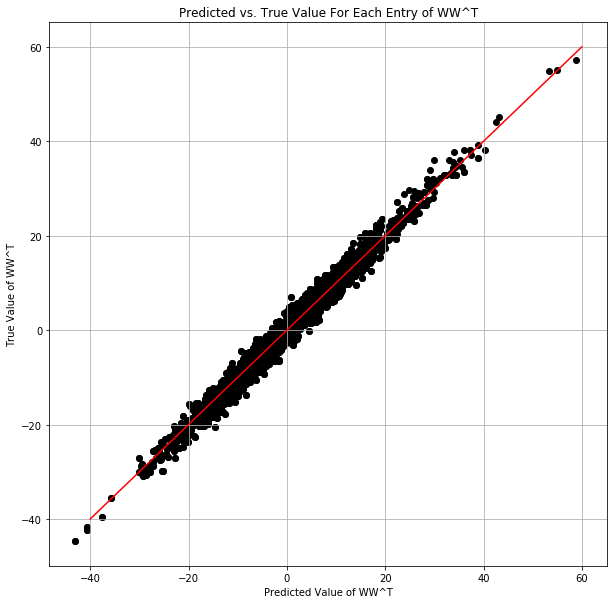

In [175]:
x = np.linspace(-40, 60, 100)
y = x
plt.scatter(WWT_pred, WWT_GT, color='black')
plt.plot(x, y, color='red')
plt.title("Predicted vs. True Value For Each Entry of WW^T")
plt.grid()
plt.ylabel('True Value of WW^T')
plt.xlabel('Predicted Value of WW^T')
print(pearsonr(WWT_GT, WWT_pred))